In [1]:
## Compare parameter values for EKI and history matching at iteration 1
import os
import glob
import csv

import sys
sys.path.insert(0,'../../History-Matching-Core/src/')

import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from cmcrameri import cm
plt.rcParams.update({'font.size': 22})

In [2]:
from history_matching.emulator import GPEmulator, implausibility

## Get data

### Parameters

In [240]:
## Create array
n_its = 10
N = 10
basedir = os.environ['GROUP_SCRATCH']+f"/EKI_N{N}/"
plotdir = f"{basedir}/PLOTS/"

params_files = [f"{basedir}/iteration_{n}/paramlist.csv" for n in range(0,n_its)]
params = [np.genfromtxt(params_file, delimiter=',', skip_header=1) for params_file in params_files]


param_arr = np.zeros((n_its, N, 2))
for i in range(n_its):
    param_arr[i] = params[i][:, 1:]

iter_ind = np.arange(n_its)

In [241]:
param_arr.shape, iter_ind.shape

((10, 10, 2), (10,))

### Outputs

In [242]:
## QBO files
QBO_dir = [f"{basedir}/iteration_{n}/" for n in range(0,n_its)]
QBO_arr = np.zeros((n_its, N, 2))
QBO_var = np.zeros((n_its, N, 2))
N_cycles = np.zeros((n_its, N))
for i in range(n_its):
    for j in range(N):
        QBO_file = f"{QBO_dir[i]}{j}/QBO_TT_metrics.csv"
        QBO_vals = np.genfromtxt(QBO_file, delimiter=',', skip_header=1)
        QBO_arr[i, j] = QBO_vals[1:3]
        QBO_var[i, j] = QBO_vals[[3, 6]]
        N_cycles[i, j] = QBO_vals[7]


In [243]:
param_arr.shape, QBO_arr.shape, QBO_var.shape

((10, 10, 2), (10, 10, 2), (10, 10, 2))

In [244]:
## Parameter values and outputs: collapse first two axes to get all values up to this iteration
param = param_arr.reshape((N*n_its, 2))
outputs = QBO_arr.reshape((N*n_its, 2))
outputs_var = QBO_var.reshape((N*n_its, 2))
outputs_std = np.sqrt(outputs_var)
outputs_stderr = np.sqrt(outputs_var / N_cycles.reshape((N*n_its))[:,None])

In [245]:
param.shape, outputs.shape, outputs_var.shape

((100, 2), (100, 2), (100, 2))

### QBO truth data

In [246]:
## Get QBO truth
truthdir = "/home/users/lauraman/EKI_OBS/ground_truth_data"
truth_filename = "QBO_TT_metrics_ground_truth.csv"

filepath_truth = f"{truthdir}/{truth_filename}"
QBO_truth = np.genfromtxt(filepath_truth, delimiter=',', skip_header=1)

In [247]:
QBO_period_truth = QBO_truth[1]
QBO_amp_truth = QBO_truth[2]
QBO_period_sd = np.sqrt(QBO_truth[3])
QBO_amp_sd = np.sqrt(QBO_truth[-1])

In [248]:
## Covariance truth
Gamma_obs = np.array((QBO_truth[3:5], QBO_truth[5:7]))

## Scaler

In [249]:
## For params, use priors for min-max scaling  cw: (0 to 75), Bt_eq (1e-3 to 7e-3)
param_min = np.array( [0, 1e-3] )
param_max = np.array( [75, 8e-3] )
param_scaled = (param - param_min) / (param_max - param_min ) 

In [250]:
## For outputs, use max and min over dataset 
outputs_min = np.min(outputs, axis=0)
outputs_max = np.max(outputs, axis=0)
outputs_scaled = (outputs - outputs_min) / (outputs_max - outputs_min ) 


In [251]:
## Scale std
outputs_std_scaled = outputs_std / (outputs_max - outputs_min)
outputs_stderr_scaled = outputs_stderr / (outputs_max - outputs_min)

In [252]:
## Check values all between 0 and 1
param_scaled, outputs_scaled

(array([[0.35938335, 0.42608578],
        [0.63849392, 0.03278149],
        [0.98500518, 0.2844117 ],
        [0.12648105, 0.84255058],
        [0.1954377 , 0.42925649],
        [0.93487555, 0.19034254],
        [0.73186089, 0.66553296],
        [0.80358856, 0.5740338 ],
        [0.49138912, 0.70376349],
        [0.45499822, 0.12115164],
        [0.45939141, 0.36008973],
        [1.0370025 , 0.20411373],
        [0.80250612, 0.31029287],
        [0.23849967, 0.95514783],
        [0.4547565 , 0.56361638],
        [0.79177136, 0.26617732],
        [0.77617027, 0.41365616],
        [0.80562541, 0.45058662],
        [0.5658362 , 0.49207723],
        [0.84719658, 0.27416188],
        [0.56439687, 0.28997647],
        [0.96791649, 0.26264797],
        [0.70521686, 0.40287661],
        [0.58583653, 0.63127192],
        [0.83201713, 0.27979596],
        [0.63164168, 0.43567661],
        [0.75213994, 0.45492177],
        [0.82228655, 0.46500889],
        [0.77880525, 0.31419254],
        [0.761

## Emulator

In [253]:
emulator = GPEmulator()


In [270]:
emulator.fit(param_scaled, outputs_scaled, outputs_std_scaled )

In [271]:
emulator

GPEmulator()

In [272]:
## Create grid of parameter space:
Ngrid = 100
cw = np.linspace(0., 1, Ngrid)       # 0 to 75
Bt = np.linspace(0, 1, Ngrid)    # 1e-3 to 7e-3
cwgrid, Btgrid = np.meshgrid(cw , Bt)

In [273]:
params_grid = np.vstack((cwgrid.flatten(), Btgrid.flatten()))

In [274]:
emulator_pred_scaled, emulator_err_scaled = emulator.predict(params_grid.T, return_std=True)


In [275]:
## unscale
emulator_pred =  emulator_pred_scaled  * (outputs_max + outputs_min) + outputs_min 
emulator_err =   emulator_err_scaled  * (outputs_max + outputs_min)

In [276]:
period = emulator_pred[:, 0].reshape((Ngrid, Ngrid))
amp = emulator_pred[:, 1].reshape((Ngrid, Ngrid))


In [277]:
period

array([[52.73964863, 52.73196552, 52.722524  , ..., 52.67690571,
        52.72601468, 52.7652472 ],
       [52.73631606, 52.72790793, 52.7175924 , ..., 52.71870618,
        52.76792365, 52.80681066],
       [52.73267969, 52.72351513, 52.71229348, ..., 52.77125062,
        52.82006803, 52.85811513],
       ...,
       [47.75427677, 47.10240429, 46.39939239, ..., 52.70152716,
        52.71015557, 52.7179517 ],
       [47.86247387, 47.22416286, 46.53573415, ..., 52.7149021 ,
        52.72185964, 52.72814351],
       [48.00017854, 47.37932157, 46.70967781, ..., 52.72595995,
        52.73153333, 52.73656499]])

In [278]:
period_err = emulator_err[:, 0].reshape((Ngrid, Ngrid))
amp_err = emulator_err[:, 1].reshape((Ngrid, Ngrid))


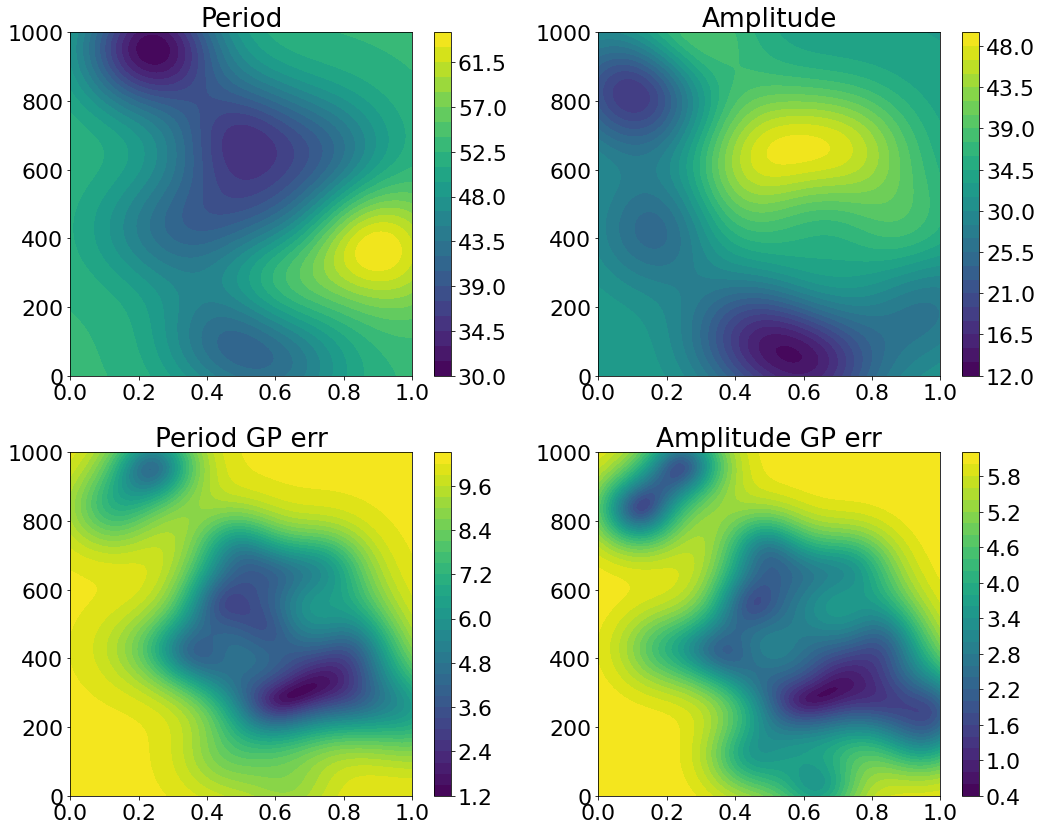

In [279]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
plt.sca(axs[0,0])
plt.contourf(cwgrid, Btgrid*1e3, period, levels = 30)
plt.colorbar()
plt.title("Period")
plt.sca(axs[0,1])
plt.contourf(cwgrid, Btgrid*1e3, amp, levels = 30)
plt.colorbar()
plt.title("Amplitude")
plt.sca(axs[1,0])
plt.contourf(cwgrid, Btgrid*1e3, period_err, levels = 30)
plt.colorbar()
plt.title("Period GP err")
plt.sca(axs[1,1])
plt.contourf(cwgrid, Btgrid*1e3, amp_err, levels = 30)
plt.colorbar()
plt.title("Amplitude GP err")
plt.tight_layout()

## Log Likelihood

In [280]:
## Log likelihood
def log_likelihood(y_pred, truth):
    LL = - np.sum((( y_pred - truth ).T  *  np.linalg.inv(Gamma_obs) * (y_pred - truth) / 2.))
    return LL

In [281]:
truth_values = np.array([QBO_period_truth, QBO_amp_truth])
log_likelihood_values = np.zeros(emulator_pred.shape[0])
for i in range(emulator_pred.shape[0]):
    log_likelihood_values[i]=log_likelihood(emulator_pred[i,:], truth_values)

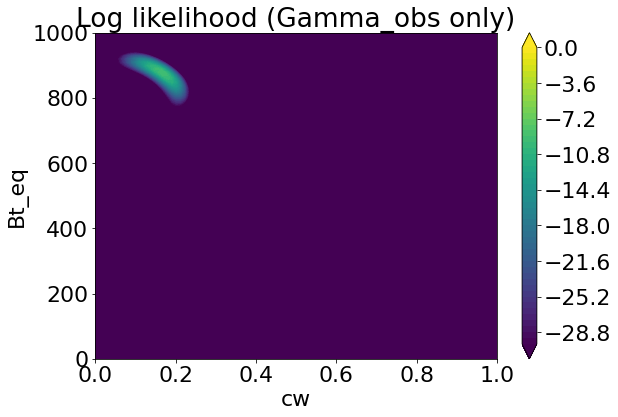

In [282]:
fig, ax = plt.subplots(1, 1, figsize=(9,6))

plt.contourf(cwgrid, Btgrid*1e3, 
             log_likelihood_values.reshape((Ngrid,Ngrid)),
            levels=np.linspace(-30, 0, 51),
            extend="both")
plt.xlabel("cw")
plt.ylabel("Bt_eq")
plt.title("Log likelihood (Gamma_obs only)")
plt.colorbar()

## Include GP error in log likelihood

In [283]:
## Log likelihood
def log_likelihood(y_pred, truth, y_err):
    LL = - np.sum((( y_pred - truth ).T  *  np.linalg.inv(Gamma_obs + np.diag(y_err**2)) * (y_pred - truth) / 2.))
    return LL

In [284]:
truth_values = np.array([QBO_period_truth, QBO_amp_truth])
log_likelihood_values = np.zeros(emulator_pred.shape[0])
for i in range(emulator_pred.shape[0]):
    log_likelihood_values[i]=log_likelihood(emulator_pred[i,:], truth_values, emulator_err[i,:])

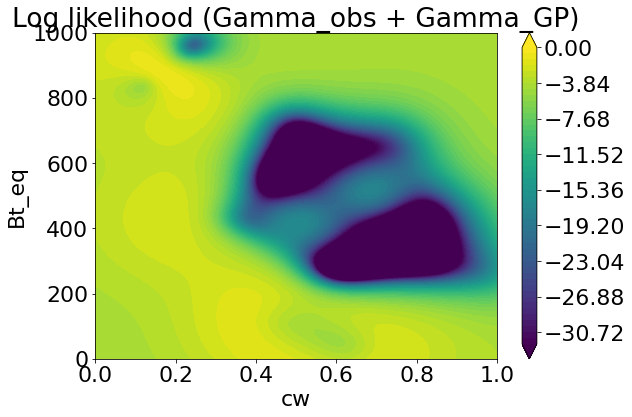

In [285]:
fig, ax = plt.subplots(1, 1, figsize=(9,6))

plt.contourf(cwgrid, Btgrid*1e3,
             log_likelihood_values.reshape((Ngrid,Ngrid)),
             levels=np.linspace(-32, 0, 51),
            extend="both")
plt.xlabel("cw")
plt.ylabel("Bt_eq")
plt.title("Log likelihood (Gamma_obs + Gamma_GP)")
plt.colorbar()